In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
amazon = pd.read_csv('_Amazon_Clothing_Sales_2025 DS12  - Amazon_Clothing_Sales_2025.csv')
amazon.head()

,order_id,customer_id,product_id,product_name,main_category,sub_category,brand,price,quantity,discount_percent,final_price,payment_method,review_rating,order_date,delivery_days,is_returned,region,customer_age_group,device_type
0,#HLWTRIGAJB0RFL,A86556872001,6Q3V14RXRF,Huggies Rompers,baby,Rompers,Huggies,118.62,1,10,106.76,PayPal,3,2024-09-10,5.0,0,Midwest,25-34,Mobile
1,#9LMWG6T6H0IPE0,0A9218115AAA,33MRMEM3WN,Gerber Blankets,Baby,Blankets,Gerber,26.84,1,15,22.81,Gift Card,2,2025-06-25,8.0,0,West,25-34,Mobile
2,#Q6J5C5621SSE5V,8A5A09200074,E674NZH16V,Fossil Jeans,Men,Jeans,Fossil,219.38,2,25,329.07,Gift Card,4,2025-01-08,5.0,0,Northeast,35-44,Mobile
3,#J145DOUKB5RVBN,97602786977A,ETMIXJHFAT,Carter's Rompers,Baby,Rompers,Carter's,12.05,1,0,12.05,Credit Card,5,2024-08-28,3.0,0,Midwest,45-54,Mobile
4,#7ZXNMSUU22AK4J,744297746010,5BYOWYYY5P,Adidas Sneakers,Kids,Sneakers,Adidas,145.36,1,10,130.82,Credit Card,1,2024-11-12,5.0,0,NaN,45-54,Mobile


In [3]:
# Check data types
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            25000 non-null  object 
 1   customer_id         25000 non-null  object 
 2   product_id          25000 non-null  object 
 3   product_name        25000 non-null  object 
 4   main_category       25000 non-null  object 
 5   sub_category        25000 non-null  object 
 6   brand               23750 non-null  object 
 7   price               24750 non-null  float64
 8   quantity            25000 non-null  int64  
 9   discount_percent    25000 non-null  int64  
 10  final_price         25000 non-null  float64
 11  payment_method      23750 non-null  object 
 12  review_rating       25000 non-null  int64  
 13  order_date          25000 non-null  object 
 14  delivery_days       24750 non-null  float64
 15  is_returned         25000 non-null  int64  
 16  regi

## A. Initial Data Exploration & Cleaning

In [4]:
# Convert order_date to datetime
amazon['order_date'] = pd.to_datetime(amazon['order_date'])

In [5]:
# Verify datatype of order_date
amazon['order_date'].dtype

dtype('<M8[ns]')

In [6]:
# Quantify missingness
missing_values = amazon.isnull().sum()
missing_percent = (missing_values/len(amazon))*100

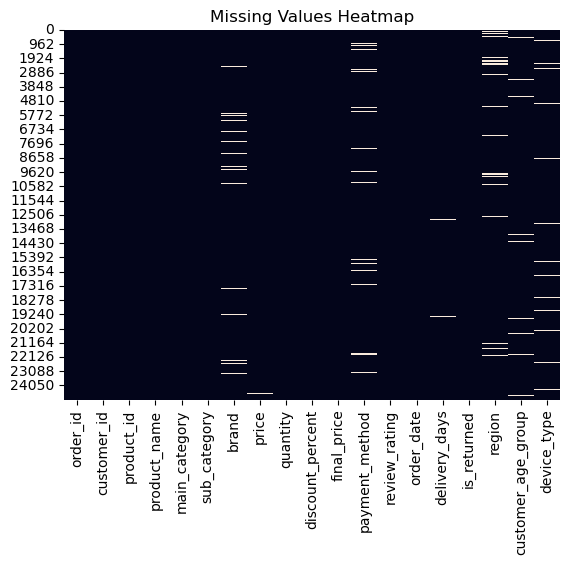

In [7]:
# Visualize missing data
sns.heatmap(amazon.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

In [8]:
# Check for duplicates
amazon.duplicated().sum()

# Validate price calculations
amazon['calculated_final'] = amazon['price'] * (1 - amazon['discount_percent']/100) * amazon['quantity']
inconsistent = amazon[abs(amazon['final_price'] - amazon['calculated_final']) > 0.01]
print(f"{len(inconsistent)} inconsistent records found")

0 inconsistent records found


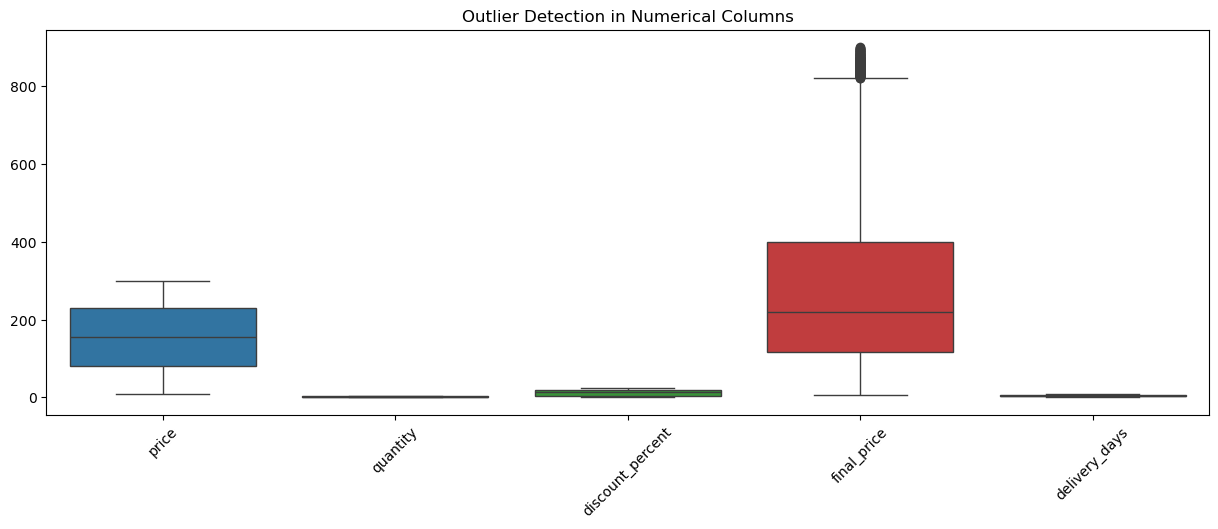

In [9]:
# Numerical columns to check for outliers
num_cols = ['price', 'quantity', 'discount_percent', 'final_price', 'delivery_days']

# Boxplot visualization
plt.figure(figsize=(15,5))
sns.boxplot(data=amazon[num_cols])
plt.title('Outlier Detection in Numerical Columns')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Date features
amazon['order_month'] = amazon['order_date'].dt.month
amazon['order_weekday'] = amazon['order_date'].dt.weekday
amazon['order_year'] = amazon['order_date'].dt.year

In [11]:
# Discount amount
amazon['discount_amount'] = amazon['price'] * amazon['discount_percent'] / 100

In [12]:
# Unit price
amazon['unit_price'] = amazon['final_price'] / amazon['quantity']

In [13]:
# Delivery speed
delivery_threshold = amazon['delivery_days'].quantile(0.75)  # Using 75th percentile as threshold
amazon['delivery_speed'] = np.where(amazon['delivery_days'] <= delivery_threshold, 'fast', 'slow')

In [14]:
# Customer-level aggregates
customer_stats = amazon.groupby('customer_id').agg(
    total_spend=('final_price', 'sum'),
    total_orders=('order_id', 'nunique'),
    avg_rating=('review_rating', 'mean'),
    return_rate=('is_returned', 'mean')
).reset_index()

# Merge back to main dataframe
amazon = amazon.merge(customer_stats, on='customer_id', how='left')

## B. Univariate Analysis

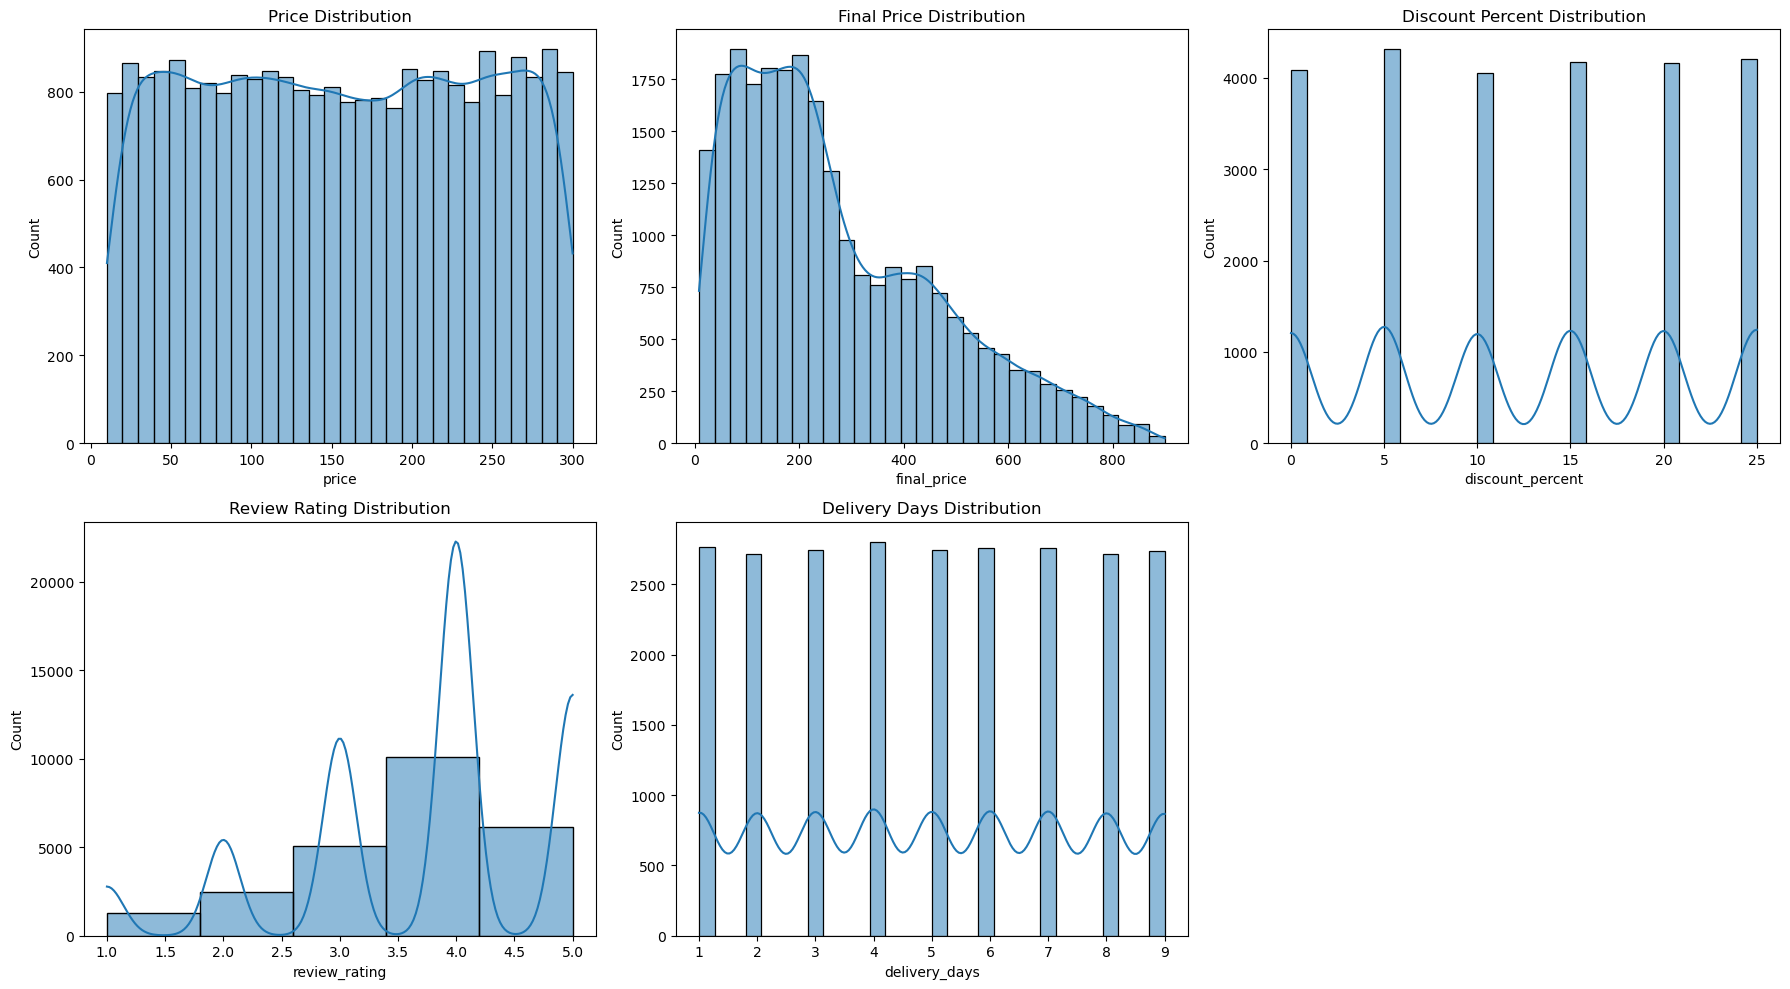

In [15]:
# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot distributions
sns.histplot(amazon['price'], bins=30, ax=axes[0,0], kde=True)
axes[0,0].set_title('Price Distribution')

sns.histplot(amazon['final_price'], bins=30, ax=axes[0,1], kde=True)
axes[0,1].set_title('Final Price Distribution')

sns.histplot(amazon['discount_percent'], bins=30, ax=axes[0,2], kde=True)
axes[0,2].set_title('Discount Percent Distribution')

sns.histplot(amazon['review_rating'], bins=5, ax=axes[1,0], kde=True)
axes[1,0].set_title('Review Rating Distribution')

sns.histplot(amazon['delivery_days'], bins=30, ax=axes[1,1], kde=True)
axes[1,1].set_title('Delivery Days Distribution')

# Remove empty subplot
fig.delaxes(axes[1,2])

plt.tight_layout()
plt.show()

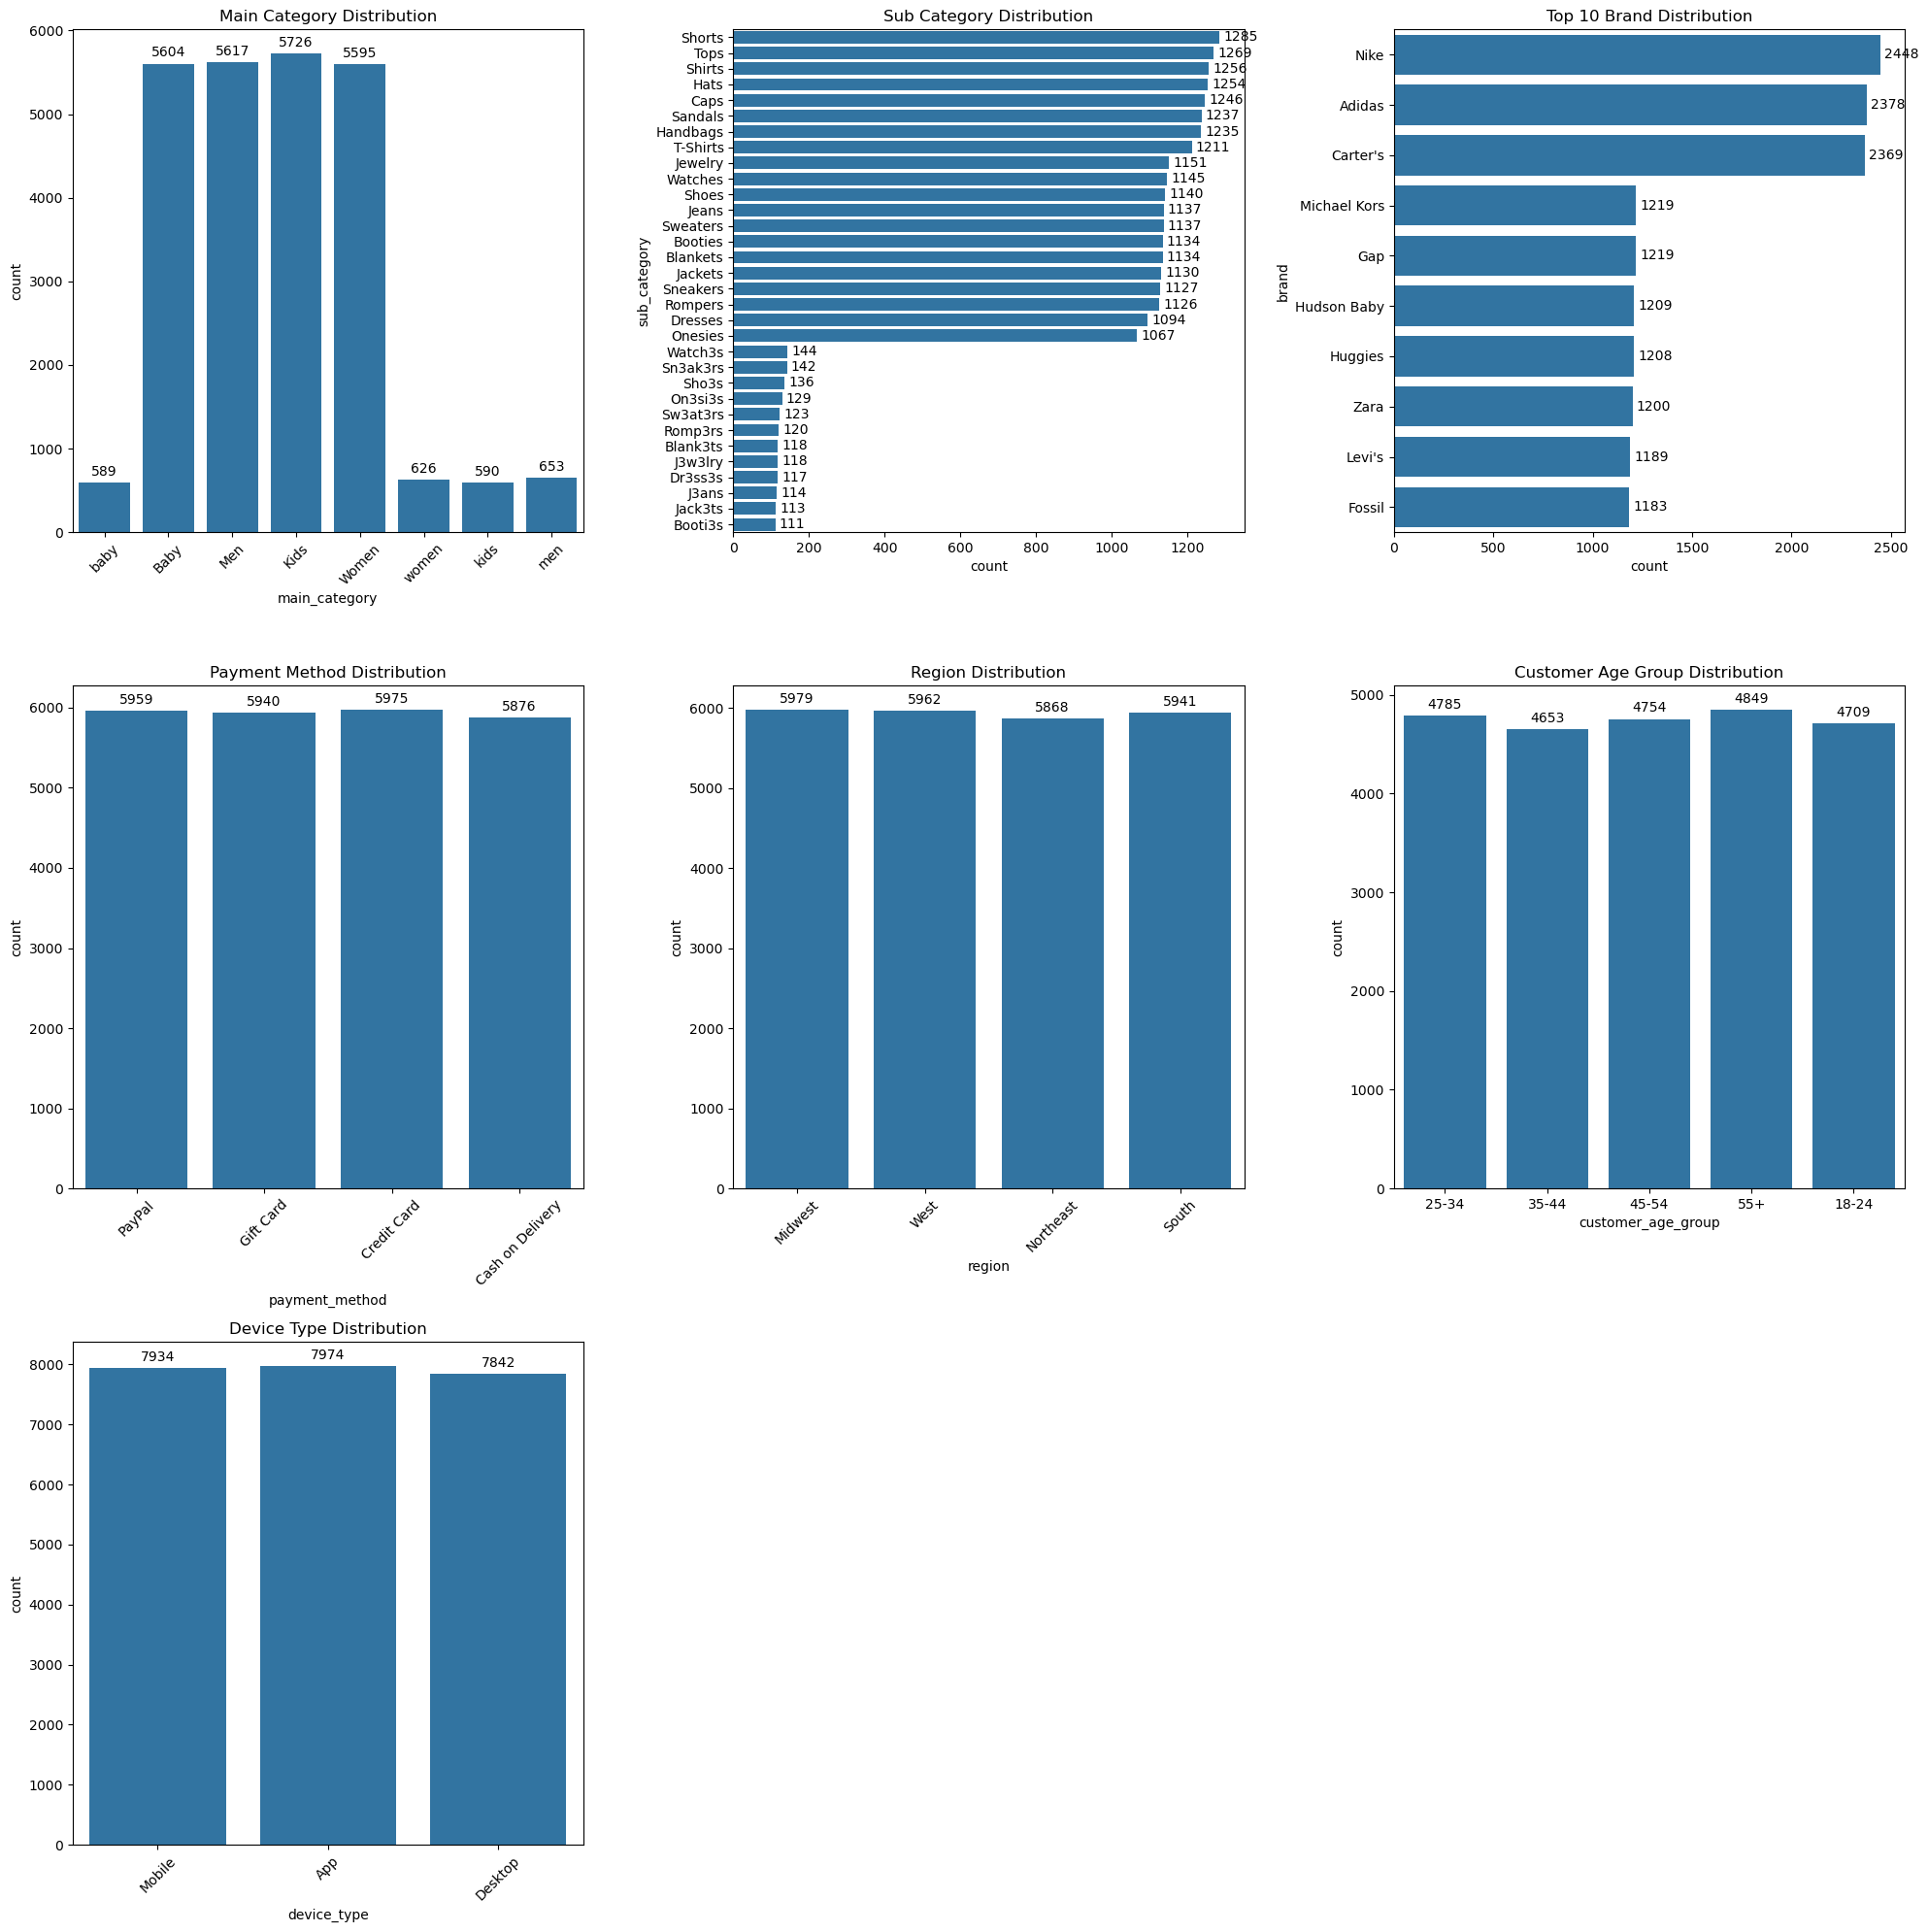

In [16]:
# Set up subplots - now 3x3 grid to accommodate all 7 plots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Plot 1: Main Category Distribution
ax = sns.countplot(data=amazon, x='main_category', ax=axes[0,0])
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[0,0].set_title('Main Category Distribution')
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Sub Category Distribution
ax1 = sns.countplot(data=amazon, y='sub_category', ax=axes[0,1], 
                   order=amazon['sub_category'].value_counts().index)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[0,1].set_title('Sub Category Distribution')

# Plot 3: Top 10 Brand Distribution
top_brands = amazon['brand'].value_counts().nlargest(10).index
ax2 = sns.countplot(data=amazon[amazon['brand'].isin(top_brands)], y='brand', 
                   ax=axes[0,2], order=top_brands)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[0,2].set_title('Top 10 Brand Distribution')

# Plot 4: Payment Method Distribution
ax3 = sns.countplot(data=amazon, x='payment_method', ax=axes[1,0])
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[1,0].set_title('Payment Method Distribution')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 5: Region Distribution
ax4 = sns.countplot(data=amazon, x='region', ax=axes[1,1])
for container in ax4.containers:
    ax4.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[1,1].set_title('Region Distribution')
axes[1,1].tick_params(axis='x', rotation=45)

# Plot 6: Customer Age Group Distribution
ax5 = sns.countplot(data=amazon, x='customer_age_group', ax=axes[1,2])
for container in ax5.containers:
    ax5.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[1,2].set_title('Customer Age Group Distribution')

# Plot 7: Device Type Distribution
ax6 = sns.countplot(data=amazon, x='device_type', ax=axes[2,0])
for container in ax6.containers:
    ax6.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
axes[2,0].set_title('Device Type Distribution')
axes[2,0].tick_params(axis='x', rotation=45)

# Remove empty subplots
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

plt.tight_layout()
plt.show()

Overall return rate: 9.84%


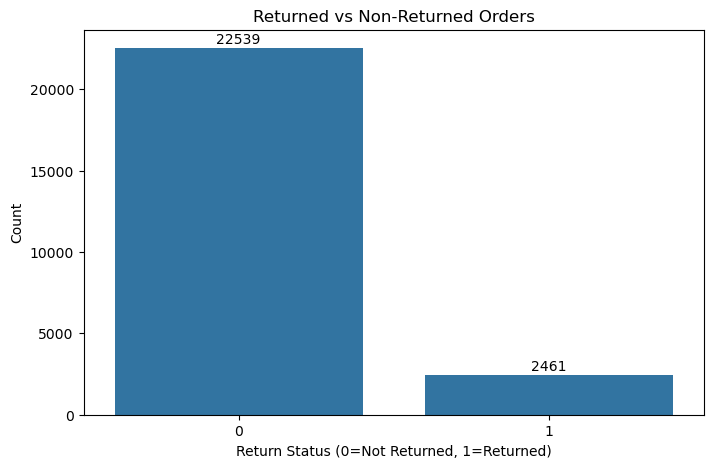

In [17]:
return_rate = amazon['is_returned'].mean()
print(f"Overall return rate: {return_rate:.2%}")

plt.figure(figsize=(8,5))
ax = sns.countplot(data=amazon, x='is_returned')
# Add count labels to each bar
for container in ax.containers:
    ax.bar_label(container, 
                fmt='%.0f',  # Format as whole numbers
                label_type='edge', 
                padding=1)  # Small space between bar and label
plt.title('Returned vs Non-Returned Orders')
plt.xlabel('Return Status (0=Not Returned, 1=Returned)')
plt.ylabel('Count')
plt.show()

## C. Bivariate & Multivariate Analysis

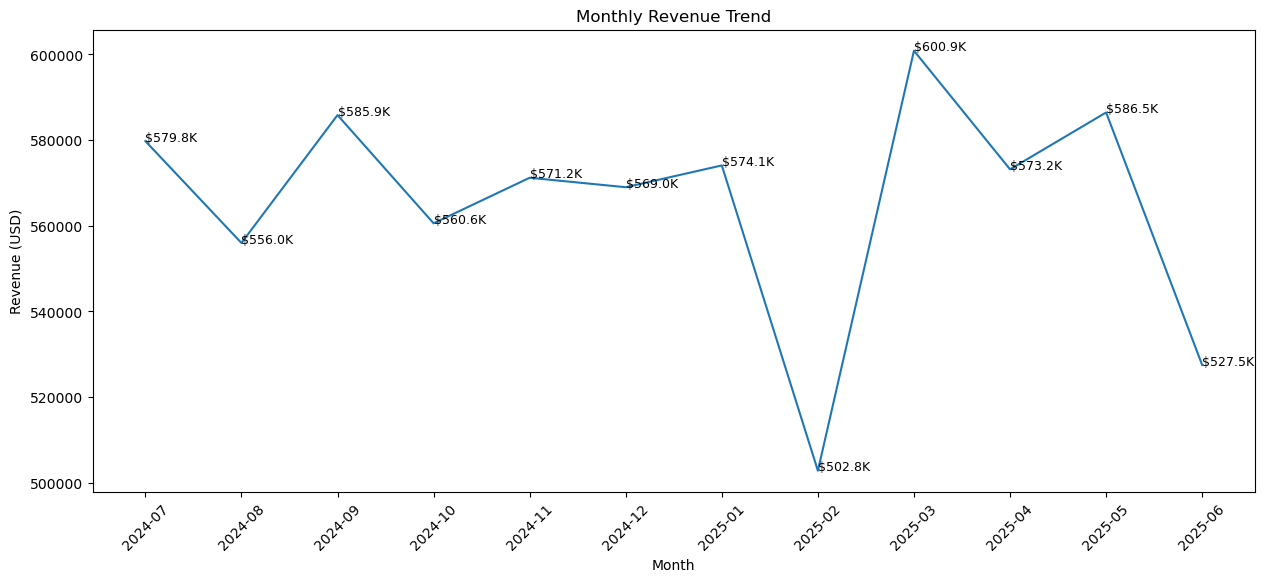

In [18]:
# Revenue over time
monthly_revenue = amazon.groupby(['order_year', 'order_month'])['final_price'].sum().reset_index()
monthly_revenue['year_month'] = monthly_revenue['order_year'].astype(str) + '-' + monthly_revenue['order_month'].astype(str).str.zfill(2)

plt.figure(figsize=(15,6))
ax = sns.lineplot(data=monthly_revenue, x='year_month', y='final_price')
for index, row in monthly_revenue.iterrows():
    ax.text(
        row['year_month'],  # x-position
        row['final_price'], # y-position
        f"${row['final_price']/1000:.1f}K",  # Format as dollars (e.g., $12.3K)
        # va='bottom',       # vertical alignment
        fontsize=9
    )
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.show()

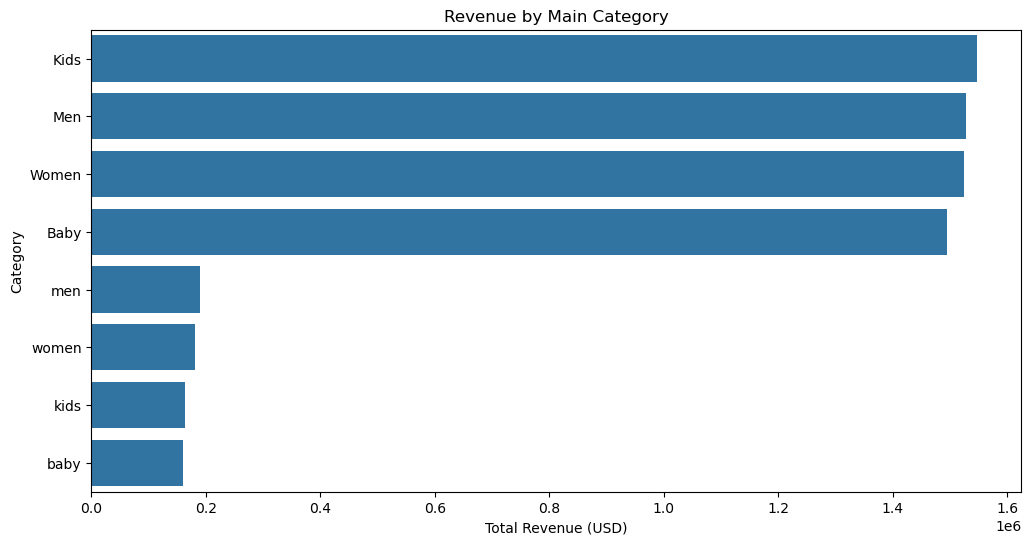

In [19]:
# Top categories/brands by revenue
top_categories = amazon.groupby('main_category')['final_price'].sum().sort_values(ascending=False)
top_brands = amazon.groupby('brand')['final_price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Revenue by Main Category')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Category')
plt.show()

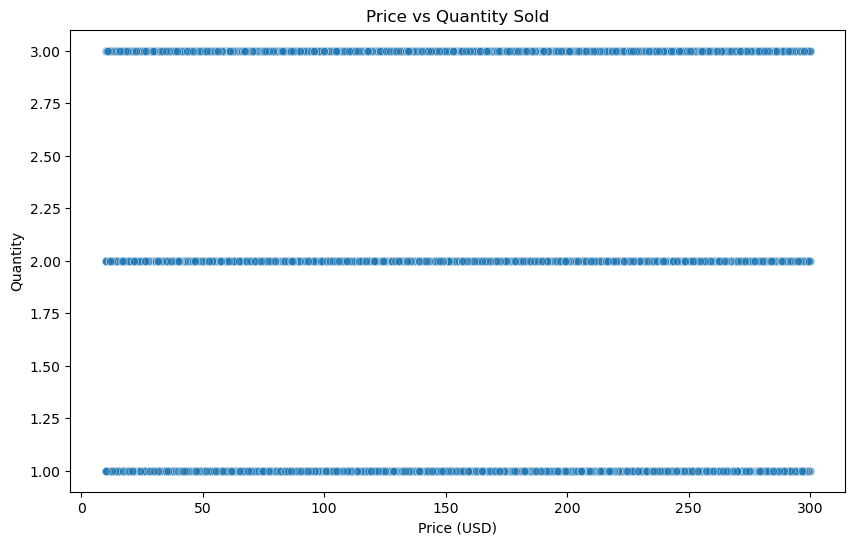

In [20]:
# Price vs quantity sold
plt.figure(figsize=(10,6))
sns.scatterplot(data=amazon, x='price', y='quantity', alpha=0.5)
plt.title('Price vs Quantity Sold')
plt.xlabel('Price (USD)')
plt.ylabel('Quantity')
plt.show()

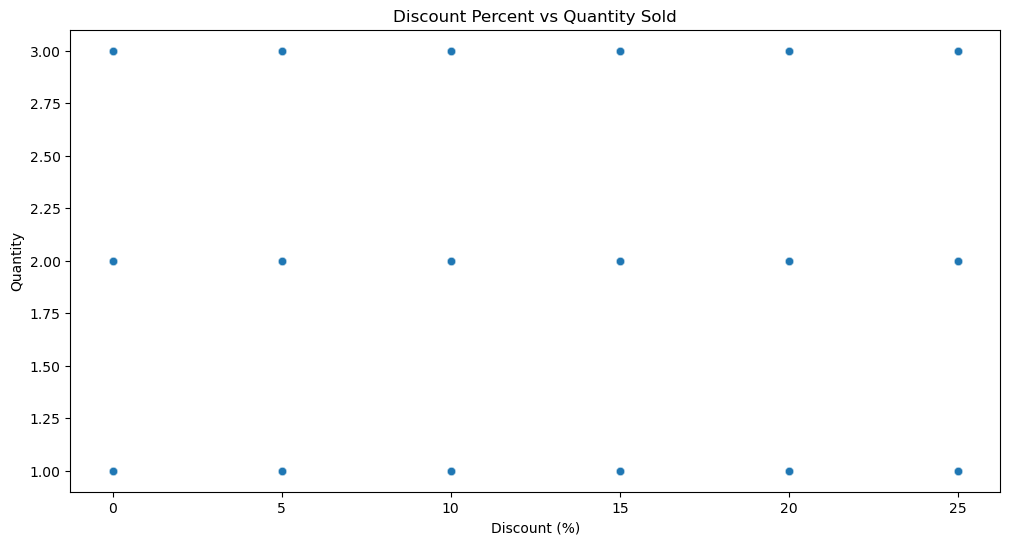

In [21]:
# Discount percent vs quantity
plt.figure(figsize=(12,6))
sns.scatterplot(data=amazon, x='discount_percent', y='quantity', alpha=0.5)
plt.title('Discount Percent vs Quantity Sold')
plt.xlabel('Discount (%)')
plt.ylabel('Quantity')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_41012\795266689.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_revenue = amazon.groupby(discount_bins)['final_price'].sum()


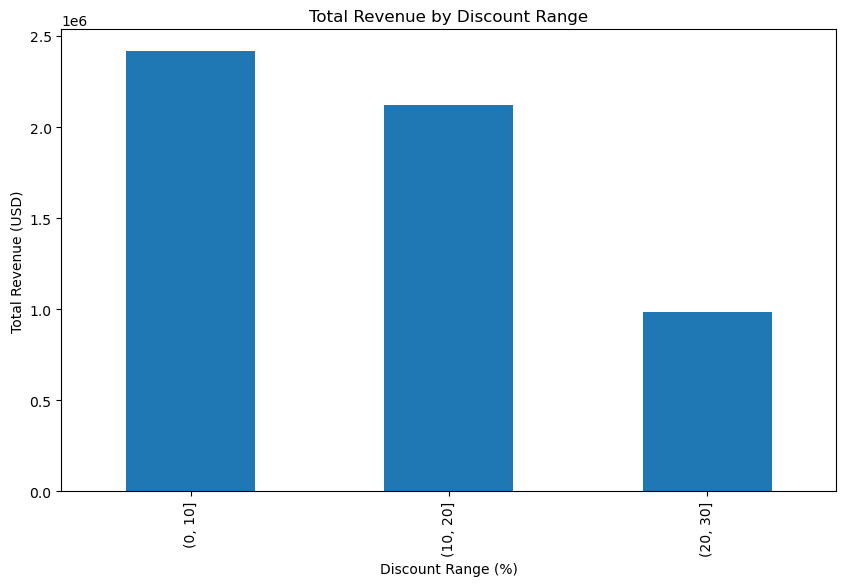

In [22]:
# Discount impact on revenue
discount_bins = pd.cut(amazon['discount_percent'], bins=[0, 10, 20, 30])
discount_revenue = amazon.groupby(discount_bins)['final_price'].sum()

plt.figure(figsize=(10,6))
discount_revenue.plot(kind='bar')
plt.title('Total Revenue by Discount Range')
plt.xlabel('Discount Range (%)')
plt.ylabel('Total Revenue (USD)')
plt.show()

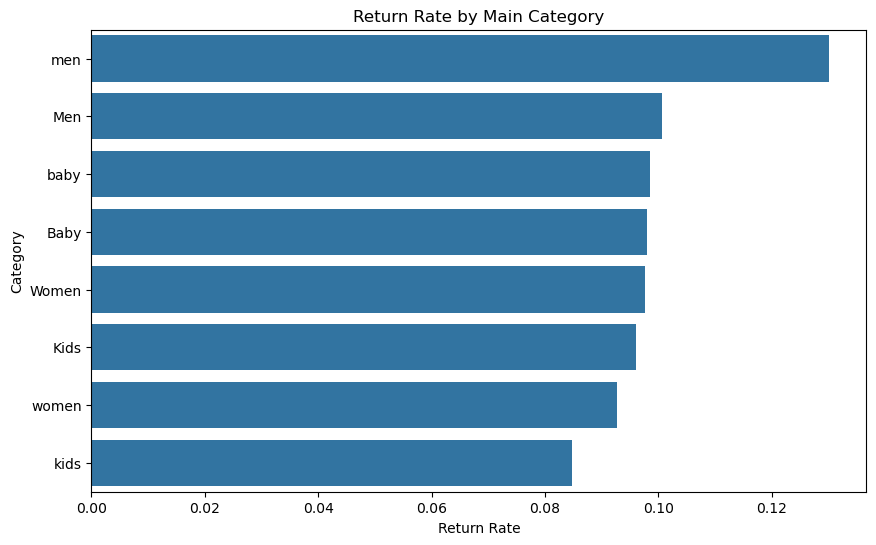

In [23]:
# Return rate by category
return_by_category = amazon.groupby('main_category')['is_returned'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=return_by_category.values, y=return_by_category.index)
plt.title('Return Rate by Main Category')
plt.xlabel('Return Rate')
plt.ylabel('Category')
plt.show()

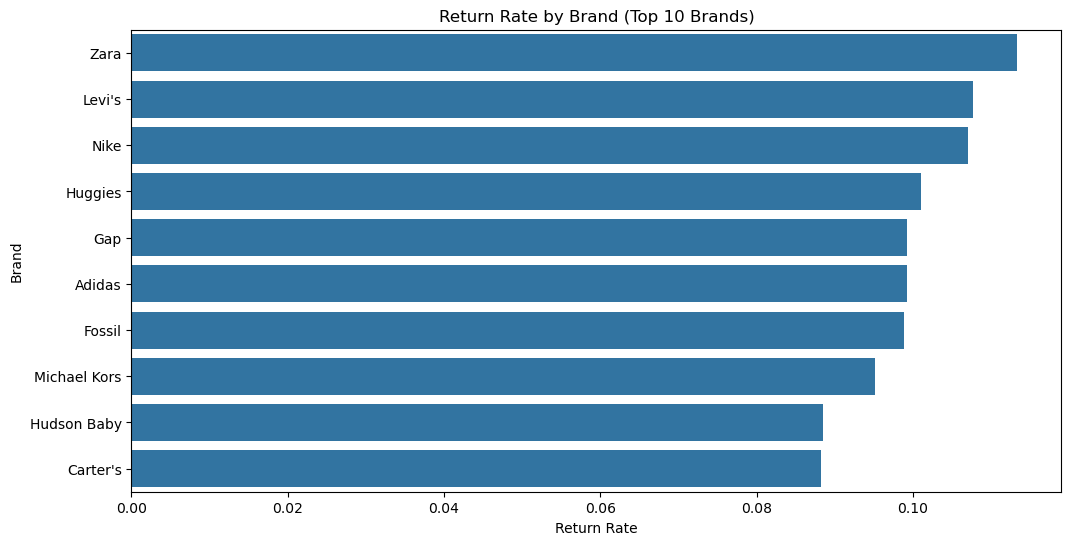

In [24]:
# Return rate by brand (top 10 brands)
top_brands_list = amazon['brand'].value_counts().nlargest(10).index
return_by_brand = amazon[amazon['brand'].isin(top_brands_list)].groupby('brand')['is_returned'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=return_by_brand.values, y=return_by_brand.index)
plt.title('Return Rate by Brand (Top 10 Brands)')
plt.xlabel('Return Rate')
plt.ylabel('Brand')
plt.show()

In [25]:
# High-value customers (top 10% by spend)
spend_threshold = amazon['total_spend'].quantile(0.9)
high_value = amazon[amazon['total_spend'] >= spend_threshold]

# Compare high-value vs regular customers
comparison = pd.DataFrame({
    'Customer Type': ['High-Value', 'Regular'],
    'Count': [len(high_value['customer_id'].unique()), 
             len(amazon['customer_id'].unique()) - len(high_value['customer_id'].unique())],
    'Avg Orders': [high_value['total_orders'].mean(), 
                  amazon[~amazon['customer_id'].isin(high_value['customer_id'])]['total_orders'].mean()],
    'Avg Spend': [high_value['total_spend'].mean(), 
                 amazon[~amazon['customer_id'].isin(high_value['customer_id'])]['total_spend'].mean()],
    'Return Rate': [high_value['is_returned'].mean(), 
                   amazon[~amazon['customer_id'].isin(high_value['customer_id'])]['is_returned'].mean()]
})

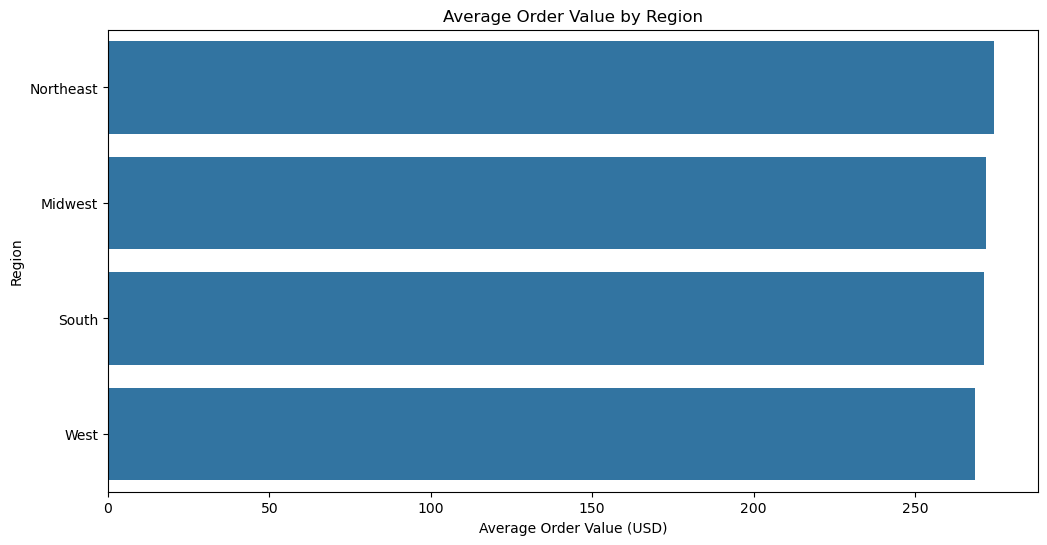

In [26]:
# AOV by region
aov_region = amazon.groupby('region')['final_price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=aov_region.values, y=aov_region.index)
plt.title('Average Order Value by Region')
plt.xlabel('Average Order Value (USD)')
plt.ylabel('Region')
plt.show()

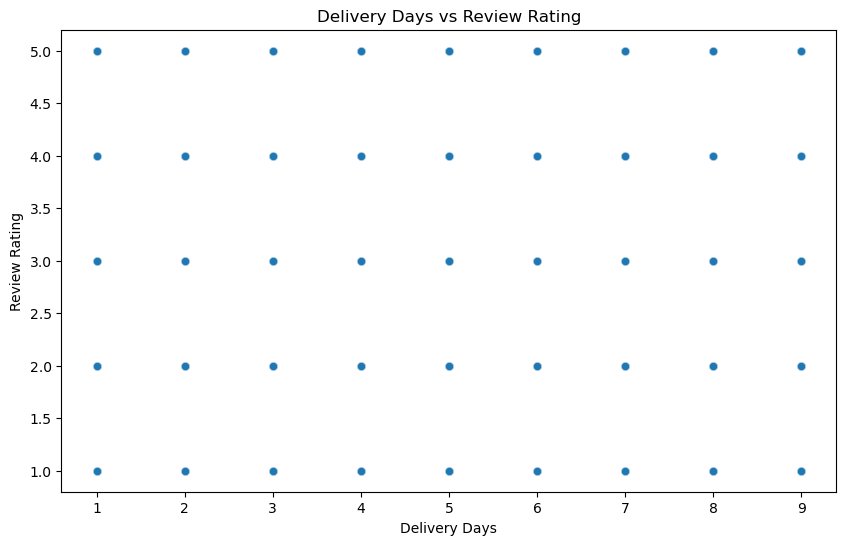

In [27]:
# Delivery days vs review rating
plt.figure(figsize=(10,6))
sns.scatterplot(data=amazon, x='delivery_days', y='review_rating', alpha=0.3)
plt.title('Delivery Days vs Review Rating')
plt.xlabel('Delivery Days')
plt.ylabel('Review Rating')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_41012\1484613549.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return_by_delivery = amazon.groupby(delivery_bins)['is_returned'].mean()


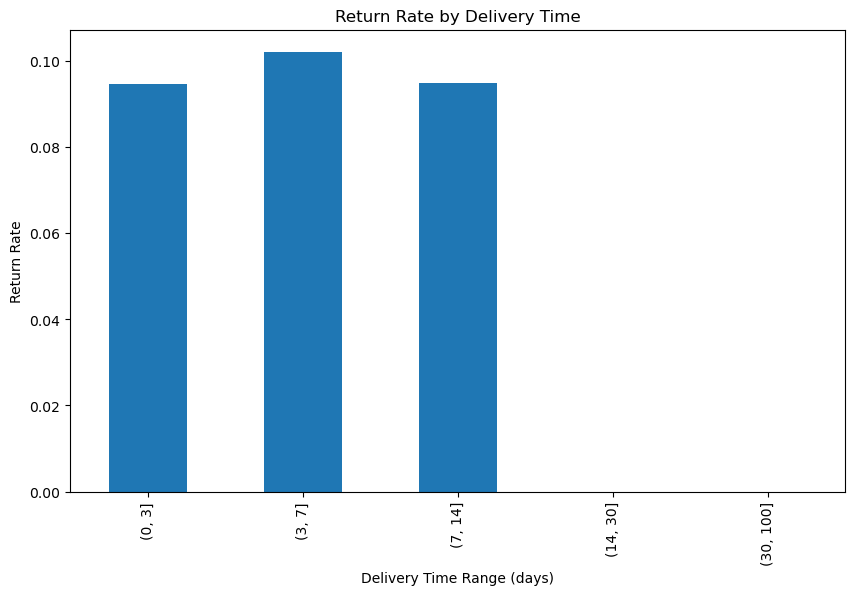

In [28]:
# Delivery days vs return probability
delivery_bins = pd.cut(amazon['delivery_days'], bins=[0, 3, 7, 14, 30, 100])
return_by_delivery = amazon.groupby(delivery_bins)['is_returned'].mean()

plt.figure(figsize=(10,6))
return_by_delivery.plot(kind='bar')
plt.title('Return Rate by Delivery Time')
plt.xlabel('Delivery Time Range (days)')
plt.ylabel('Return Rate')
plt.show()

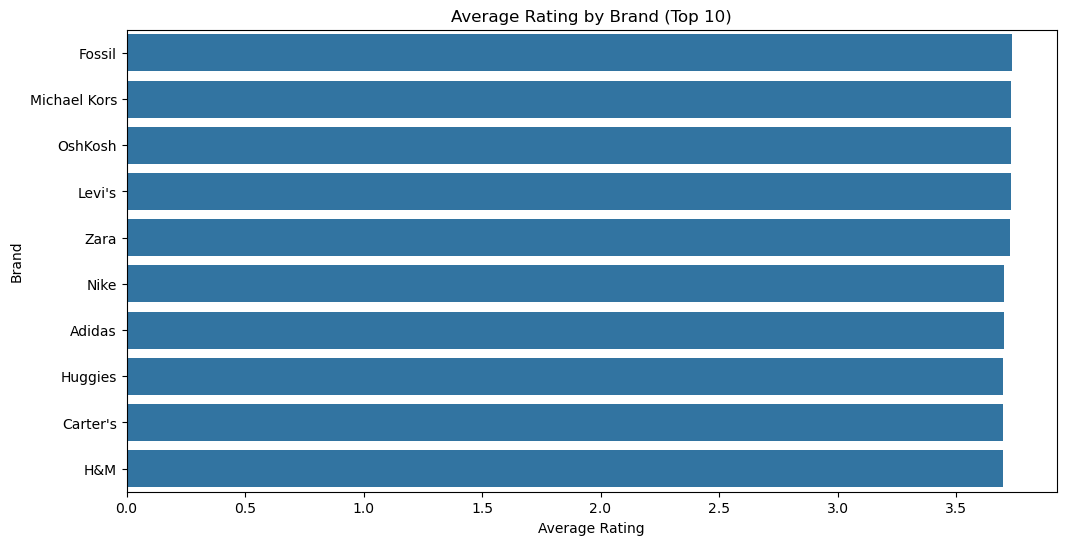

In [29]:
# Average rating by brand
avg_rating_brand = amazon.groupby('brand')['review_rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_rating_brand.values, y=avg_rating_brand.index)
plt.title('Average Rating by Brand (Top 10)')
plt.xlabel('Average Rating')
plt.ylabel('Brand')
plt.show()

In [30]:
# Low ratings and returns
low_rating = amazon[amazon['review_rating'] <= 2]
print(f"Return rate for low ratings (<=2): {low_rating['is_returned'].mean():.2%}")
print(f"Return rate for ratings >2: {amazon[amazon['review_rating'] > 2]['is_returned'].mean():.2%}")

Return rate for low ratings (<=2): 9.61%
Return rate for ratings >2: 9.88%


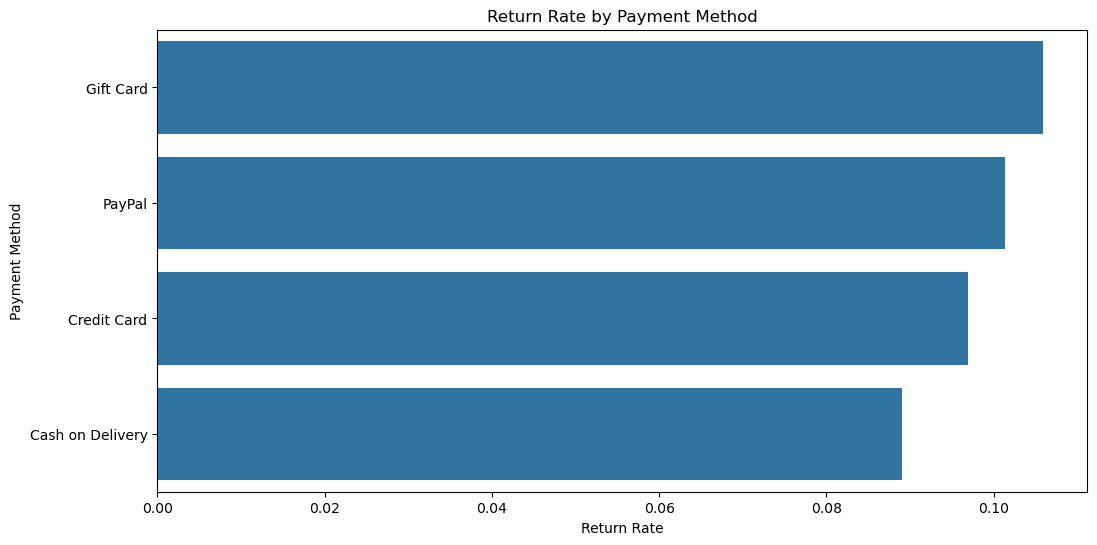

In [31]:
# Payment method vs return rate
payment_return = amazon.groupby('payment_method')['is_returned'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=payment_return.values, y=payment_return.index)
plt.title('Return Rate by Payment Method')
plt.xlabel('Return Rate')
plt.ylabel('Payment Method')
plt.show()

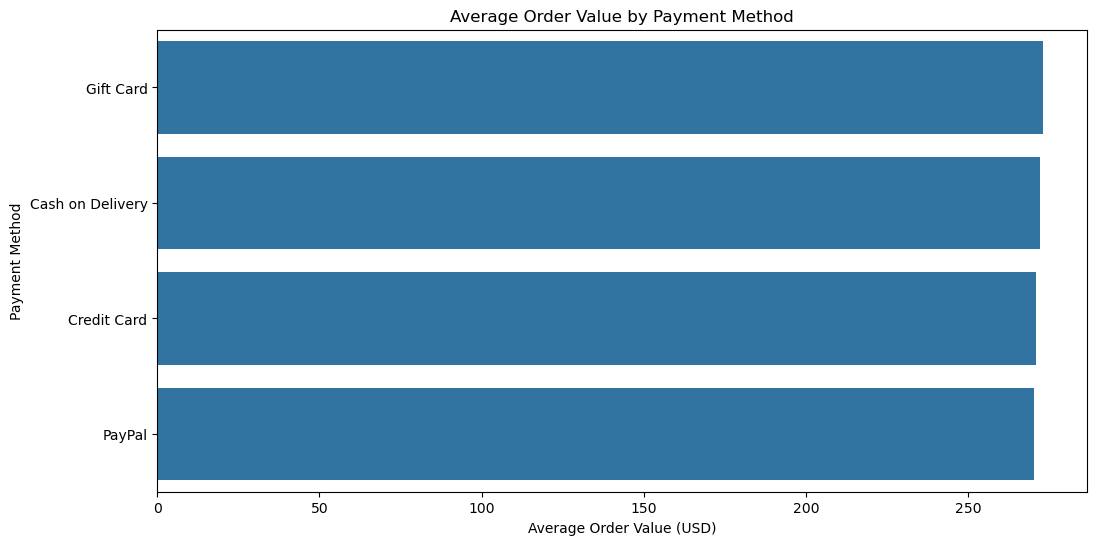

In [32]:
# Payment method vs average spend
payment_spend = amazon.groupby('payment_method')['final_price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=payment_spend.values, y=payment_spend.index)
plt.title('Average Order Value by Payment Method')
plt.xlabel('Average Order Value (USD)')
plt.ylabel('Payment Method')
plt.show()

## D. Hypothesis Ideas (picks/answers at least 5)

Correlation between discount and quantity: -0.00


C:\Users\HP\AppData\Local\Temp\ipykernel_41012\3906126085.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_return = amazon.groupby(pd.cut(amazon['discount_percent'], bins=10))['is_returned'].mean().reset_index()


Text(0, 0.5, 'Quantity')

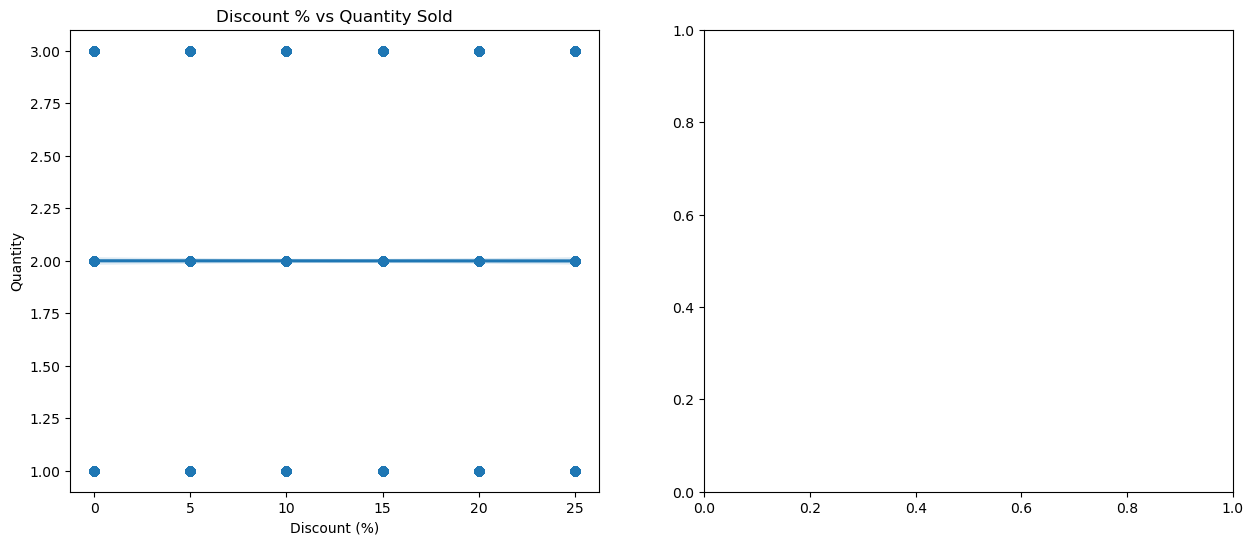

In [33]:
# Correlation between discount and quantity
discount_quantity_corr = amazon['discount_percent'].corr(amazon['quantity'])
print(f"Correlation between discount and quantity: {discount_quantity_corr:.2f}")

# Discount vs return rate
discount_return = amazon.groupby(pd.cut(amazon['discount_percent'], bins=10))['is_returned'].mean().reset_index()
discount_return['discount_range'] = discount_return['discount_percent'].apply(lambda x: x.mid)  # Use midpoint of each bin

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Scatter plot with regression
sns.regplot(data=amazon, x='discount_percent', y='quantity', ax=ax1, scatter_kws={'alpha':0.3})
ax1.set_title('Discount % vs Quantity Sold')
ax1.set_xlabel('Discount (%)')
ax1.set_ylabel('Quantity')

Correlation between delivery days and rating: 0.01
Correlation between delivery days and return probability: -0.00


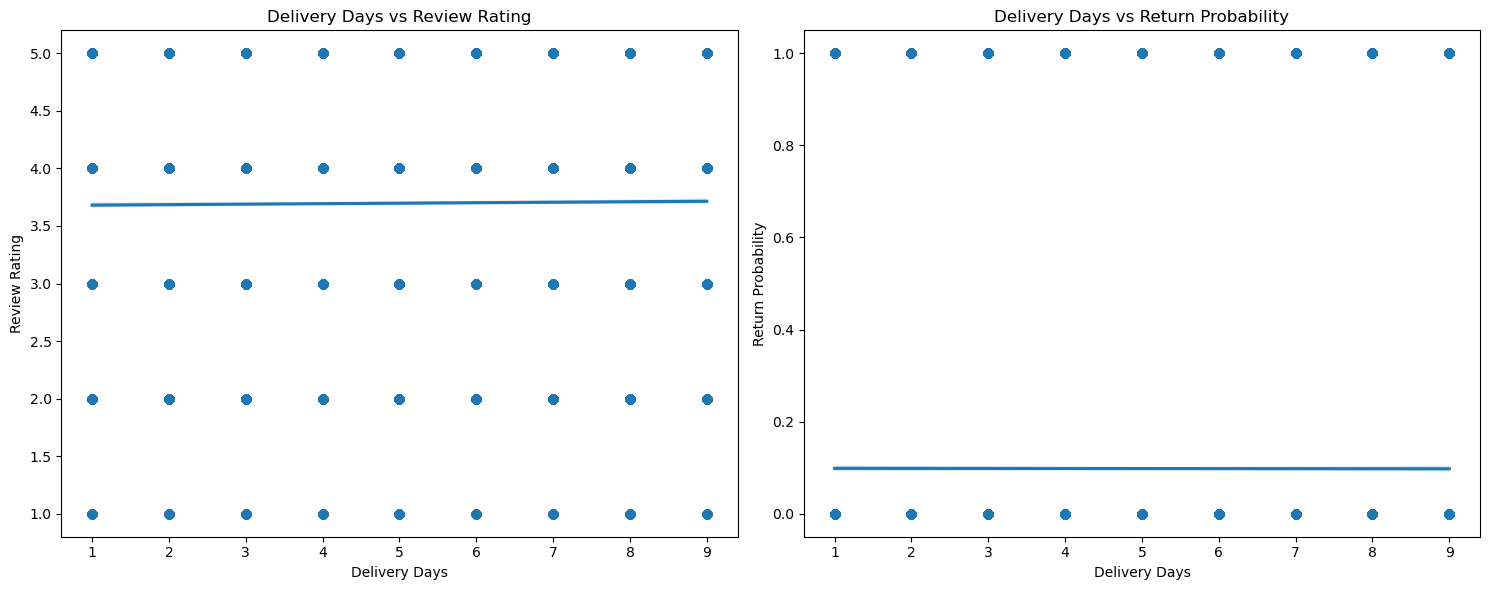

In [34]:
# Delivery days vs review rating correlation
delivery_rating_corr = amazon['delivery_days'].corr(amazon['review_rating'])
print(f"Correlation between delivery days and rating: {delivery_rating_corr:.2f}")

# Delivery days vs return rate correlation
delivery_return_corr = amazon['delivery_days'].corr(amazon['is_returned'])
print(f"Correlation between delivery days and return probability: {delivery_return_corr:.2f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.regplot(data=amazon, x='delivery_days', y='review_rating', ax=ax1, scatter_kws={'alpha':0.3})
ax1.set_title('Delivery Days vs Review Rating')
ax1.set_xlabel('Delivery Days')
ax1.set_ylabel('Review Rating')

sns.regplot(data=amazon, x='delivery_days', y='is_returned', logistic=True, ax=ax2)
ax2.set_title('Delivery Days vs Return Probability')
ax2.set_xlabel('Delivery Days')
ax2.set_ylabel('Return Probability')

plt.tight_layout()
plt.show()

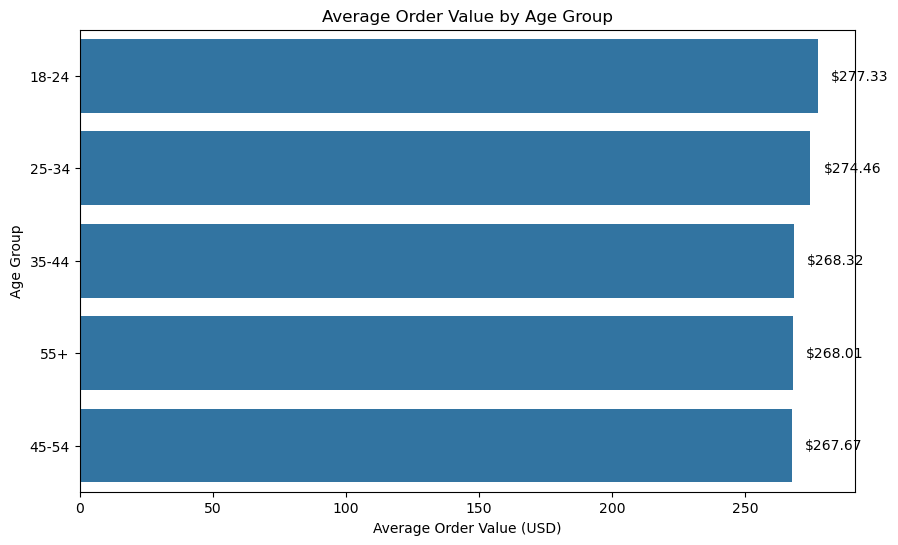

In [35]:
# AOV by age group
aov_age = amazon.groupby('customer_age_group')['final_price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x=aov_age.values, y=aov_age.index)
for p in ax.patches:
    width = p.get_width()  # Get bar width (value)
    ax.text(width + 5,       # x-position: value + small offset
           p.get_y() + p.get_height()/2,  # y-position: middle of bar
           f"${width:,.2f}",  # Formatted dollar value with 2 decimals
           ha='left', 
           va='center',
           fontsize=10)
plt.title('Average Order Value by Age Group')
plt.xlabel('Average Order Value (USD)')
plt.ylabel('Age Group')
plt.show()

              avg_spend  return_rate  count
device_type                                
Desktop      275.664350     0.100230   7842
App          271.333022     0.098445   7974
Mobile       267.931850     0.097177   7934


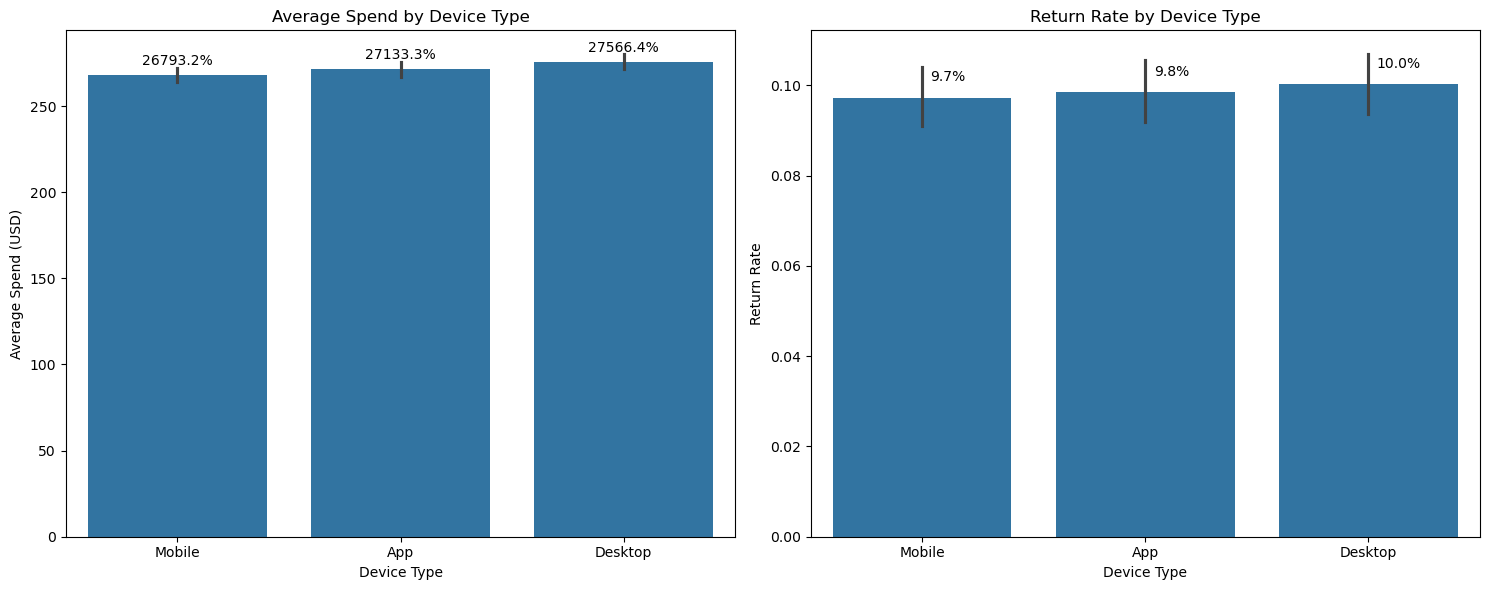

In [36]:
# Compare device types
device_comparison = amazon.groupby('device_type').agg(
    avg_spend=('final_price', 'mean'),
    return_rate=('is_returned', 'mean'),
    count=('order_id', 'count')
).sort_values('avg_spend', ascending=False)

print(device_comparison)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax = sns.barplot(data=amazon, x='device_type', y='final_price', ax=ax1)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1%}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
ax1.set_title('Average Spend by Device Type')
ax1.set_xlabel('Device Type')
ax1.set_ylabel('Average Spend (USD)')

g1 = sns.barplot(data=amazon, x='device_type', y='is_returned', ax=ax2)
for p in g1.patches:
    g1.annotate(f"{p.get_height():.1%}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(6, 12),
                textcoords='offset points'
                )
ax2.set_title('Return Rate by Device Type')
ax2.set_xlabel('Device Type')
ax2.set_ylabel('Return Rate')

plt.tight_layout()
plt.show()

          Type  Avg Price  Return Rate
0      Premium  158.94668     0.102776
1  Non-Premium  153.97713     0.096709


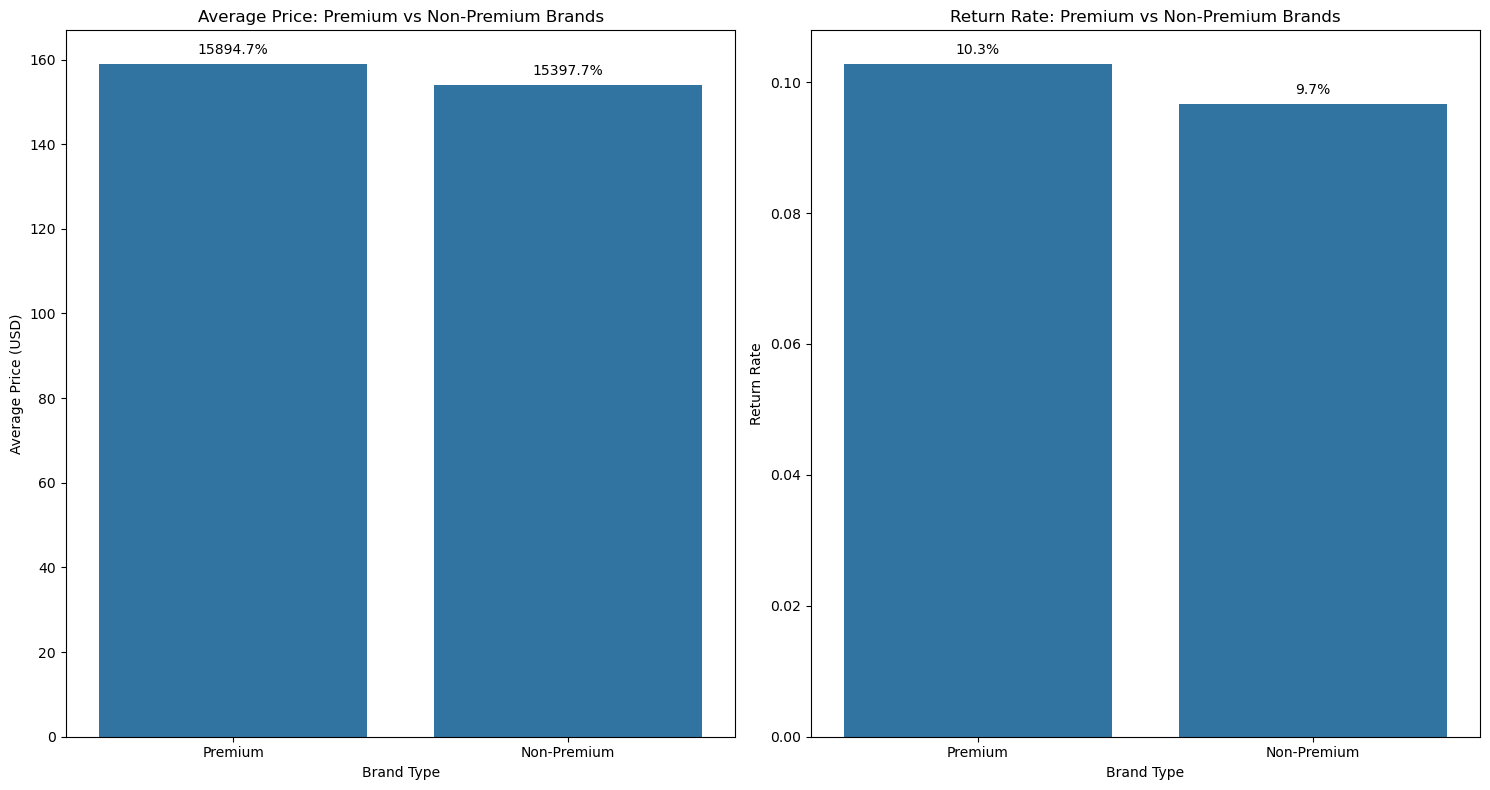

In [37]:
# Identify premium brands (top 5 by average price)
premium_brands = amazon.groupby('brand')['price'].mean().nlargest(5).index

# Compare premium vs non-premium
premium = amazon[amazon['brand'].isin(premium_brands)]
non_premium = amazon[~amazon['brand'].isin(premium_brands)]

comparison = pd.DataFrame({
    'Type': ['Premium', 'Non-Premium'],
    'Avg Price': [premium['price'].mean(), non_premium['price'].mean()],
    'Return Rate': [premium['is_returned'].mean(), non_premium['is_returned'].mean()]
})

print(comparison)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

gr1 = sns.barplot(data=comparison, x='Type', y='Avg Price', ax=ax1)
# Add percentage labels to return rate bars
for p in gr1.patches:
    gr1.annotate(f"{p.get_height():.1%}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
ax1.set_title('Average Price: Premium vs Non-Premium Brands')
ax1.set_xlabel('Brand Type')
ax1.set_ylabel('Average Price (USD)')

gr2 = sns.barplot(data=comparison, x='Type', y='Return Rate', ax=ax2)
# Add percentage labels to return rate bars
for p in gr2.patches:
    gr2.annotate(f"{p.get_height():.1%}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
ax2.set_title('Return Rate: Premium vs Non-Premium Brands')
ax2.set_xlabel('Brand Type')
ax2.set_ylabel('Return Rate')

plt.tight_layout()
plt.show()

## E. Advanced Analyses 

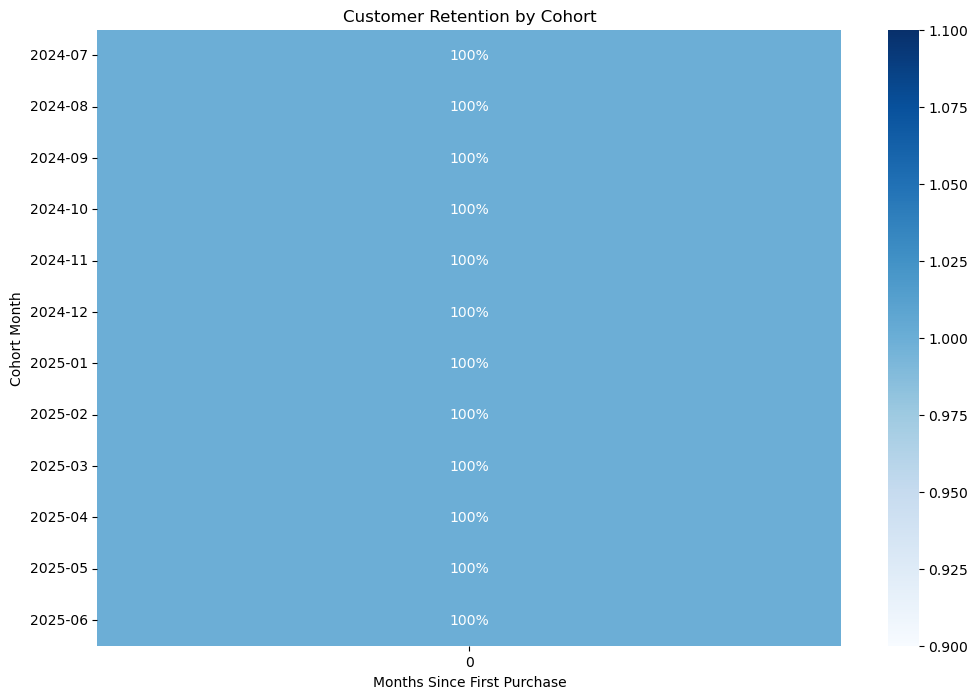

In [38]:
# Create cohort groups based on first purchase month
amazon['cohort_month'] = amazon.groupby('customer_id')['order_date'].transform('min').dt.to_period('M')
amazon['order_month'] = amazon['order_date'].dt.to_period('M')

# Calculate cohort index (months since first purchase)
amazon['cohort_index'] = (amazon['order_month'] - amazon['cohort_month']).apply(lambda x: x.n)

# Create cohort matrix
cohort_data = amazon.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort_matrix = cohort_data.pivot_table(index='cohort_month', columns='cohort_index', values='customer_id')

# Calculate retention rates
cohort_size = cohort_matrix.iloc[:,0]
retention_matrix = cohort_matrix.divide(cohort_size, axis=0)

# Visualization
plt.figure(figsize=(12,8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Customer Retention by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

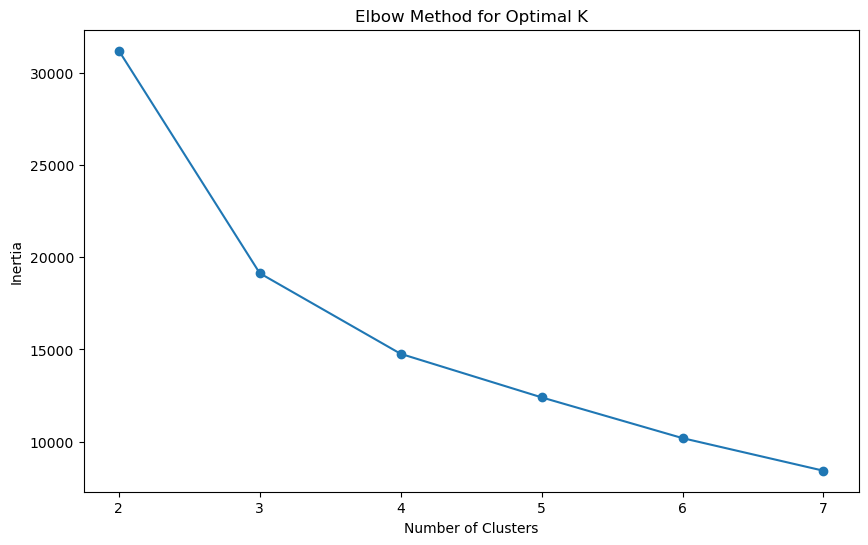

            recency frequency  monetary      
               mean      mean      mean count
cluster                                      
0        274.791850  0.693147  5.785501  8417
1         93.561349  0.693147  4.348734  4507
2         91.912032  0.693147  5.829880  8037
3        274.666006  0.693147  4.219683  4039


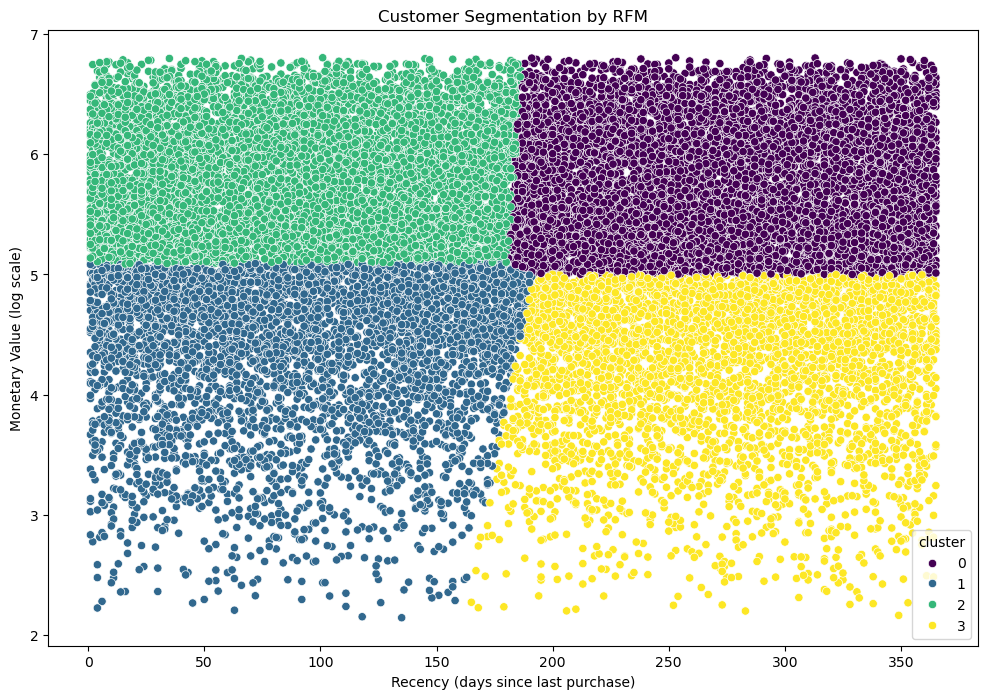

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Calculate RFM metrics
current_date = amazon['order_date'].max() + pd.Timedelta(days=1)

rfm = amazon.groupby('customer_id').agg({
    'order_date': lambda x: (current_date - x.max()).days,  # Recency
    'order_id': 'nunique',  # Frequency
    'final_price': 'sum'  # Monetary
}).rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'final_price': 'monetary'
})

# Log transform monetary and frequency
rfm['monetary'] = np.log1p(rfm['monetary'])
rfm['frequency'] = np.log1p(rfm['frequency'])

# Standardize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Determine optimal clusters
inertia = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2,8), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze clusters
cluster_summary = rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
})

print(cluster_summary)

# Visualization
plt.figure(figsize=(12,8))
sns.scatterplot(data=rfm, x='recency', y='monetary', hue='cluster', palette='viridis')
plt.title('Customer Segmentation by RFM')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary Value (log scale)')
plt.show()

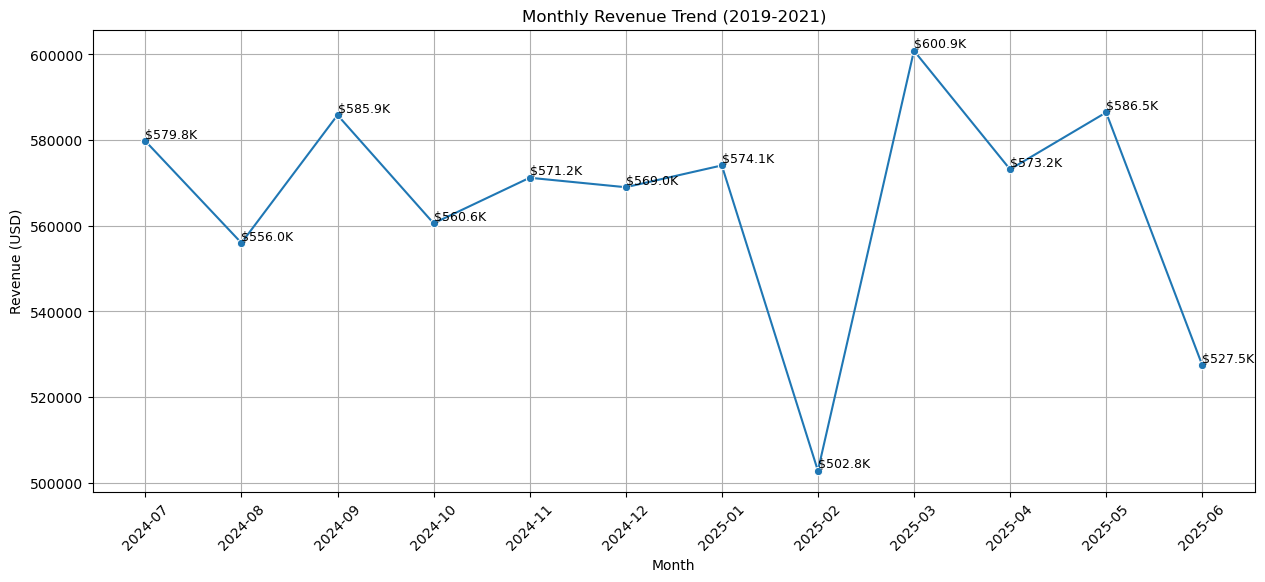

In [40]:
plt.figure(figsize=(15,6))
ax = sns.lineplot(data=monthly_revenue, x='year_month', y='final_price', marker='o')

# Add labels to each point - using monthly_revenue instead of discount_return
for index, row in monthly_revenue.iterrows():
    ax.text(
        row['year_month'],  # x-position
        row['final_price'], # y-position
        f"${row['final_price']/1000:.1f}K",  # Format as dollars (e.g., $12.3K)
        va='bottom',       # vertical alignment
        fontsize=9
    )

plt.title('Monthly Revenue Trend (2019-2021)')
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

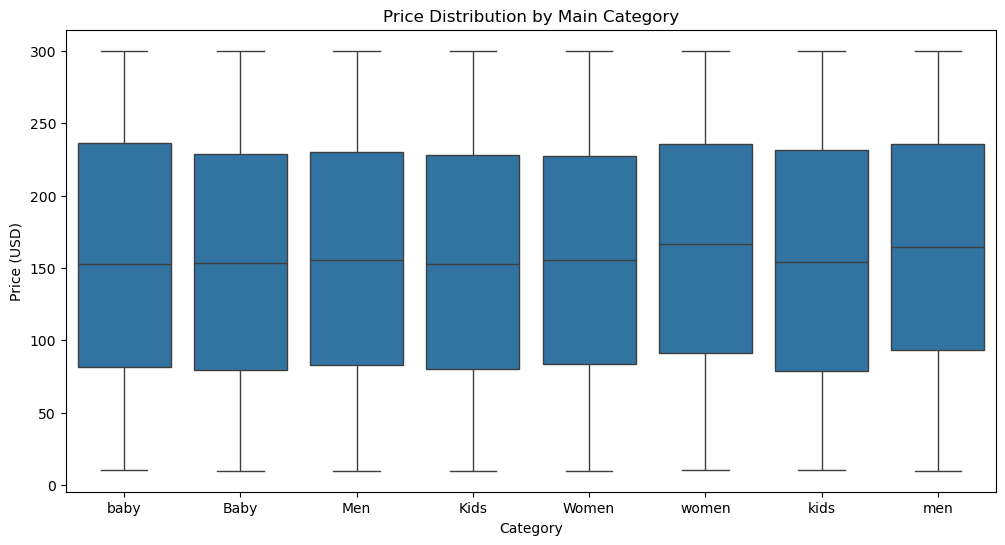

In [41]:
plt.figure(figsize=(12,6))
sns.boxplot(data=amazon, x='main_category', y='price')
plt.title('Price Distribution by Main Category')
plt.xlabel('Category')
plt.ylabel('Price (USD)')
plt.show()
# Shows significant price variation across categories with Women's category having the widest range.

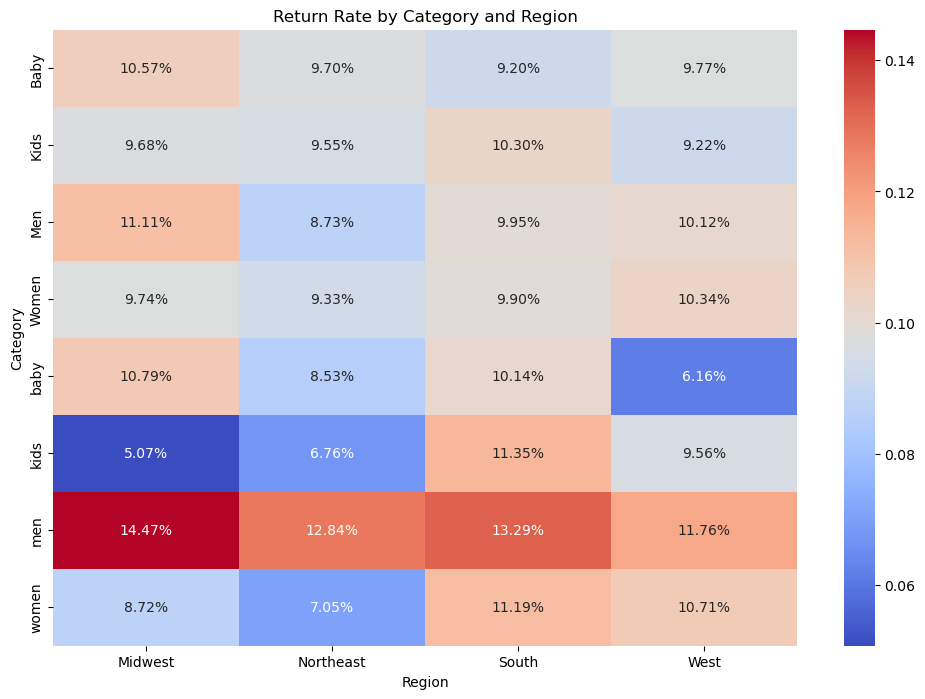

In [42]:
pivot_table = amazon.pivot_table(index='main_category', columns='region', values='is_returned', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(pivot_table, annot=True, fmt='.2%', cmap='coolwarm')
plt.title('Return Rate by Category and Region')
plt.xlabel('Region')
plt.ylabel('Category')
plt.show()
# Reveals regional differences in return behavior across product categories.

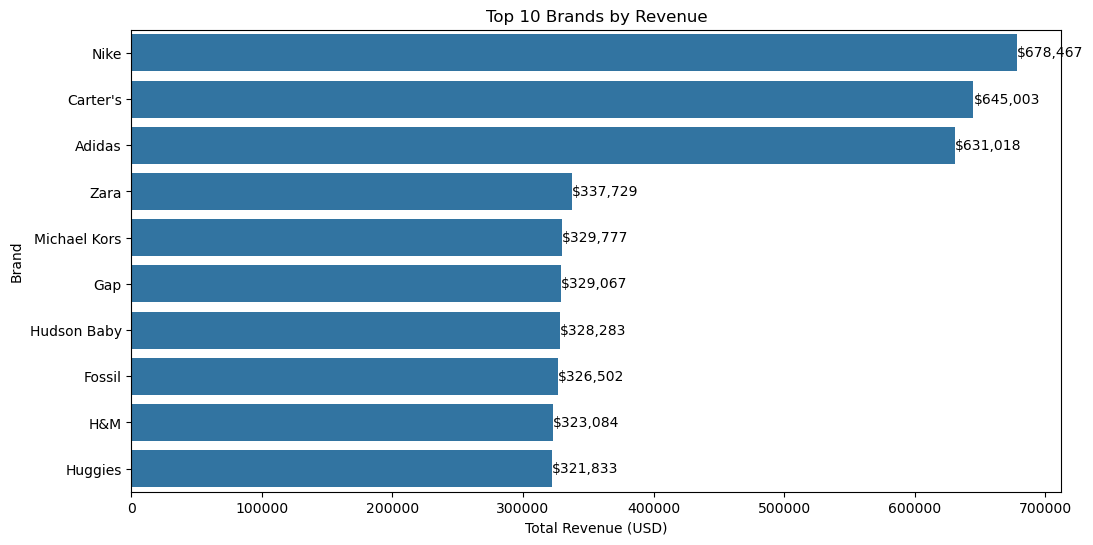

In [43]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=top_brands.values, y=top_brands.index)
# Add labels to each bar
for i, (value, name) in enumerate(zip(top_brands.values, top_brands.index)):
    # Format the value with commas and dollar sign
    formatted_value = f"${value:,.0f}"
    ax.text(
        value,          # x-position (value of the bar)
        i,              # y-position (index of the bar)
        formatted_value, # label text
        ha='left',      # horizontal alignment (left side of the bar)
        va='center',    # vertical alignment (center of the bar)
        fontsize=10,
        color='black',
    )
plt.title('Top 10 Brands by Revenue')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Brand')
plt.show()
# Highlights the top performing brands that drive most revenue.

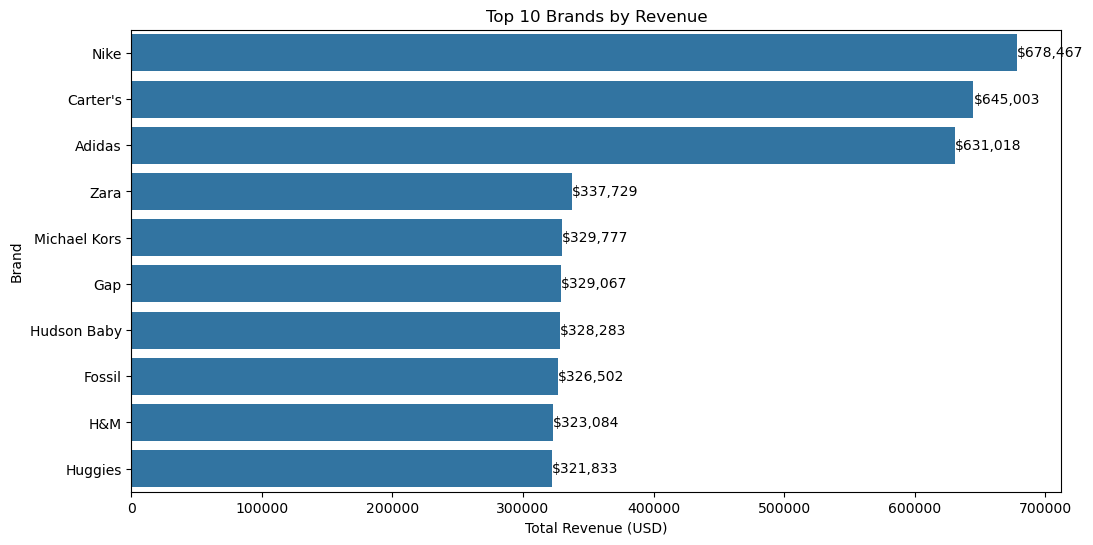

In [44]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=top_brands.values, y=top_brands.index)
# Add labels to each bar
for i, (value, name) in enumerate(zip(top_brands.values, top_brands.index)):
    # Format the value with commas and dollar sign
    formatted_value = f"${value:,.0f}"
    ax.text(
        value,          # x-position (value of the bar)
        i,              # y-position (index of the bar)
        formatted_value, # label text
        ha='left',      # horizontal alignment (left side of the bar)
        va='center',    # vertical alignment (center of the bar)
        fontsize=10,
        color='black',
    )
plt.title('Top 10 Brands by Revenue')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Brand')
plt.show()
# Highlights the top performing brands that drive most revenue.

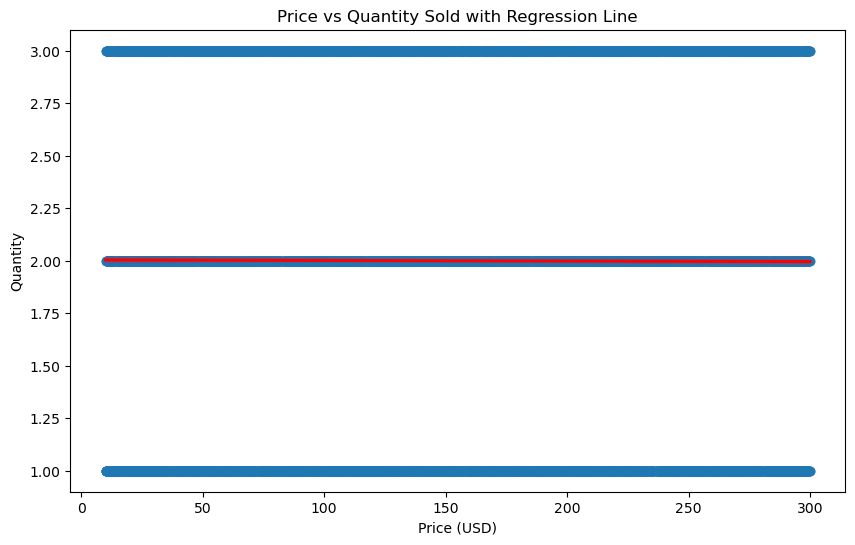

In [45]:
plt.figure(figsize=(10,6))
sns.regplot(data=amazon, x='price', y='quantity', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Price vs Quantity Sold with Regression Line')
plt.xlabel('Price (USD)')
plt.ylabel('Quantity')
plt.show()
# Shows negative correlation between price and quantity sold.